In [11]:
import os, sys, pybamm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
solver = pybamm.CasadiSolver(
    mode="safe",
    rtol=1e-5,  # 상대 허용 오차 증가 → Solver가 더 유연해짐
    atol=1e-5,  # 절대 허용 오차 증가 → Solver가 작은 수치 변화에 덜 민감해짐
    root_method="hybr",  # 초기 조건 찾기 알고리즘을 SciPy의 "hybr"로 변경
    root_tol=1e-5,  # 루트 허용 오차 증가
    max_step_decrease_count=10,  # 스텝 크기 감소 허용 횟수를 증가시켜 Solver가 더 많은 시도 가능
    dt_max=100,  # 최대 시간 스텝을 100초로 줄여 수치적 안정성 증가
    extrap_tol=1e-6,  # 외삽 허용 오차 추가
    extra_options_setup={"max_num_steps": 100000, "print_stats": False},  # CasADi 설정 변경
    return_solution_if_failed_early=True,  # Solver가 실패해도 일부 결과 반환
    perturb_algebraic_initial_conditions=False,  # 초기 조건의 작은 교란 비활성화
    integrators_maxcount=200,  # 통합기 개수 증가 (메모리 사용 증가 가능)
)

In [3]:
# SPM으로 시작
spm = pybamm.lithium_ion.SPM(options={'thermal': 'lumped', "lithium plating": "partially reversible",})
spm.default_parameter_values.search('Nominal cell capacity [A.h]')
spm.default_parameter_values.search('Upper voltage cut-off [V]')
spm.default_parameter_values.search('Lower voltage cut-off [V]')
print("------------------------------------")
param = pybamm.ParameterValues("OKane2022")
param.search('Nominal cell capacity [A.h]')
param.search('Upper voltage cut-off [V]')
param.search('Lower voltage cut-off [V]')

/home/hpark/anaconda3/envs/torch_base/lib/python3.9/site-packages/pybamm/models/full_battery_models/base_battery_model.py:910: OptionWarning: The 'lumped' thermal option with 'dimensionality' 0 now uses the parameters 'Cell cooling surface area [m2]', 'Cell volume [m3]' and 'Total heat transfer coefficient [W.m-2.K-1]' to compute the cell cooling term, regardless of the value of the the 'cell geometry' option. Please update your parameters accordingly.
  options = BatteryModelOptions(extra_options)


Nominal cell capacity [A.h]	0.680616
Upper voltage cut-off [V]	4.1
Lower voltage cut-off [V]	3.105
------------------------------------
Nominal cell capacity [A.h]	5.0
Upper voltage cut-off [V]	4.2
Lower voltage cut-off [V]	2.5


In [4]:
protocol = 'CCCV'

v_up = param['Upper voltage cut-off [V]']; v_low = param['Lower voltage cut-off [V]']; C = -param['Nominal cell capacity [A.h]']
# 1C CC-CV
globals()[f'{protocol}'] = pybamm.Experiment(
    [(
        pybamm.step.c_rate(-1, termination=f'{v_up}V'),
        pybamm.step.voltage(v_up, termination="C/100"),
        "Rest for 15 minutes",
        pybamm.step.c_rate(1, termination=f'{v_low}V'),
        "Rest for 15 minutes",
    )] * 1000, termination="80% capacity",
)

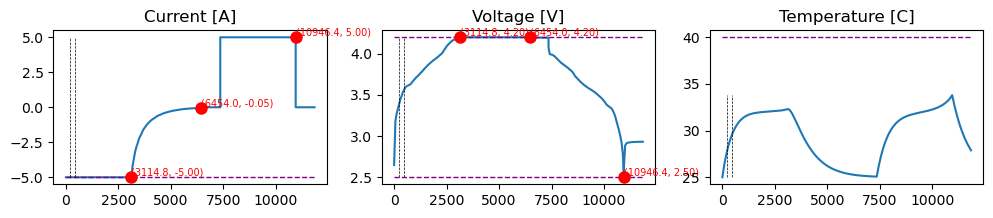

In [88]:
model, protocol = 'spm', 'CCCV'

globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'], parameter_values=param, solver=solver)
globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(initial_soc=0)
t = globals()[f'sol_{model}_{protocol}']['Time [s]'].entries
i = globals()[f'sol_{model}_{protocol}']['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}']['Cell temperature [C]'].entries[0]
desired_t = [step.t_event[0] for step in globals()[f'sol_{model}_{protocol}'].cycles[0].steps if step.t_event is not None]
i_at_desired_t = globals()[f'sol_{model}_{protocol}']['Current [A]'](desired_t)
v_at_desired_t = globals()[f'sol_{model}_{protocol}']['Voltage [V]'](desired_t)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
ax1.plot(t, i); ax1.hlines(y=[C], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax1.set_title('Current [A]')
ax1.plot(desired_t, i_at_desired_t, 'ro', markersize=8)
for dt, current_val in zip(desired_t, i_at_desired_t):
    ax1.text(dt, current_val, f"({dt:.1f}, {current_val:.2f})", color='red', fontsize=7, verticalalignment='bottom')
ax2.plot(t, v); ax2.hlines(y=[v_up, v_low], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax2.set_title('Voltage [V]')
ax2.plot(desired_t, v_at_desired_t, 'ro', markersize=8)
for dt, voltage_val in zip(desired_t, v_at_desired_t):
    ax2.text(dt, voltage_val, f"({dt:.1f}, {voltage_val:.2f})", color='red', fontsize=7, verticalalignment='bottom')
ax3.plot(t, T); ax3.hlines(y=[40], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax3.set_title('Temperature [C]')

xs = [449.208, 209.203]
ax1.vlines(x=xs, ymin=min(i), ymax=max(i), color='black', linestyle='--', lw=0.5); ax2.vlines(x=xs, ymin=min(v), ymax=max(v), color='black', linestyle='--', lw=0.5); ax3.vlines(x=xs, ymin=min(T), ymax=max(T), color='black', linestyle='--', lw=0.5)

In [49]:
protocol = 'MCCCV'

v_up = param['Upper voltage cut-off [V]']; v_low = param['Lower voltage cut-off [V]']; C = -param['Nominal cell capacity [A.h]']
# Arbitary 3 stages MCC-CV
globals()[f'{protocol}'] = pybamm.Experiment(
    [(
        pybamm.step.c_rate(-2, termination=f'{v_up-0.2}V'),
        pybamm.step.c_rate(-1, termination=f'{v_up-0.1}V'),
        pybamm.step.c_rate(-0.5, termination=f'{v_up}V'),
        pybamm.step.voltage(v_up, termination="C/100"),
        "Rest for 15 minutes",
        pybamm.step.c_rate(1, termination=f'{v_low}V'),
        "Rest for 15 minutes",
    )], termination="80% capacity",
)

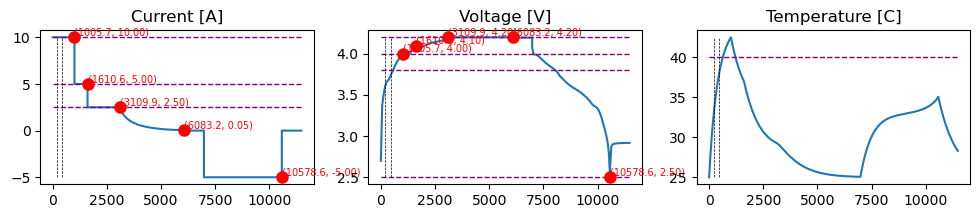

In [51]:
model, protocol = 'spm', 'MCCCV'

globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'], parameter_values=param, solver=solver)
globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(initial_soc=0)
t = globals()[f'sol_{model}_{protocol}']['Time [s]'].entries
i = -globals()[f'sol_{model}_{protocol}']['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}']['Cell temperature [C]'].entries[0]
desired_t = [step.t_event[0] for step in globals()[f'sol_{model}_{protocol}'].cycles[0].steps if step.t_event is not None]
i_at_desired_t = -globals()[f'sol_{model}_{protocol}']['Current [A]'](desired_t)
v_at_desired_t = globals()[f'sol_{model}_{protocol}']['Voltage [V]'](desired_t)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
ax1.plot(t, i); ax1.hlines(y=[-2*C, -1*C, -0.5*C], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax1.set_title('Current [A]')
ax1.plot(desired_t, i_at_desired_t, 'ro', markersize=8)
for dt, current_val in zip(desired_t, i_at_desired_t):
    ax1.text(dt, current_val, f"({dt:.1f}, {current_val:.2f})", color='red', fontsize=7, verticalalignment='bottom')
ax2.plot(t, v); ax2.hlines(y=[v_up-0.4, v_up-0.2, v_up, v_low], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax2.set_title('Voltage [V]')
ax2.plot(desired_t, v_at_desired_t, 'ro', markersize=8)
for dt, voltage_val in zip(desired_t, v_at_desired_t):
    ax2.text(dt, voltage_val, f"({dt:.1f}, {voltage_val:.2f})", color='red', fontsize=7, verticalalignment='bottom')
ax3.plot(t, T); ax3.hlines(y=[40], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax3.set_title('Temperature [C]')

xs = [449.208, 209.203]
ax1.vlines(x=xs, ymin=min(i), ymax=max(i), color='black', linestyle='--', lw=0.5); ax2.vlines(x=xs, ymin=min(v), ymax=max(v), color='black', linestyle='--', lw=0.5); ax3.vlines(x=xs, ymin=min(T), ymax=max(T), color='black', linestyle='--', lw=0.5)

In [ ]:
model, protocol = 'spm', 'PC'

v_up = param['Upper voltage cut-off [V]']; v_low = param['Lower voltage cut-off [V]']; C = -param['Nominal cell capacity [A.h]']
# pulse charging
pulse_duration = 100  # 펄스 지속 시간 (예: 10초)
globals()[f'{protocol}'] = []

globals()[f'{protocol}'].append(pybamm.Experiment(
    [(pybamm.step.c_rate(-1, duration=pulse_duration/2, termination=f'{v_up}V'), 
      pybamm.step.current(0, duration=pulse_duration/2, termination=f'{v_up}V'))]))

globals()[f'{protocol}'].append(pybamm.Experiment(
    [(pybamm.step.voltage(v_up, termination="C/100"),
      "Rest for 15 minutes",
      pybamm.step.c_rate(1, termination=f'{v_low}V'),
      "Rest for 15 minutes")]))

In [5]:
model, protocol = 'spm', 'PC'
globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'][0], 
                                                         parameter_values=param, solver=solver)
globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(initial_soc=0)

flag = 0
import tqdm
for i in tqdm.tqdm(range(600)):
    globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'][0], 
                                                             parameter_values=param, solver=solver)
    globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(starting_solution=globals()[f'sol_{model}_{protocol}'])
    flag = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries[-1]
    
    if flag >= v_up:
        print(f'escape the loops with counts: {i}')
        break

globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'][1], 
                                                         parameter_values=param, solver=solver)
globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(starting_solution=globals()[f'sol_{model}_{protocol}'])

100%|█████████████████████████████████████████████████████████████████████████████████| 600/600 [03:14<00:00,  3.09it/s]


In [33]:
globals()[f'sol_{model}_{protocol}'].cycles[600].steps

Text(0.5, 1.0, 'Temperature [C]')

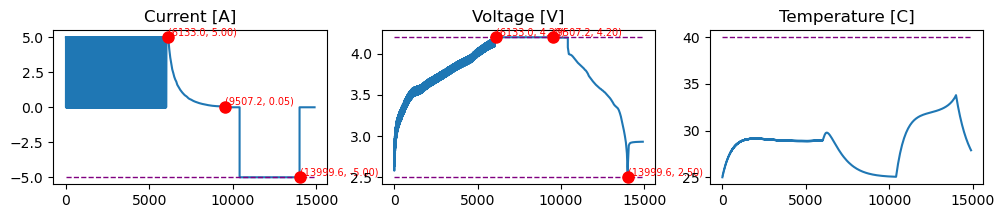

In [34]:
model, protocol = 'spm', 'PC'
t = globals()[f'sol_{model}_{protocol}']['Time [s]'].entries
i = -globals()[f'sol_{model}_{protocol}']['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}']['Cell temperature [C]'].entries[0]
desired_t = [step.t_event[0] for step in globals()[f'sol_{model}_{protocol}'].cycles[601].steps if step.t_event is not None]
i_at_desired_t = -globals()[f'sol_{model}_{protocol}']['Current [A]'](desired_t)
v_at_desired_t = globals()[f'sol_{model}_{protocol}']['Voltage [V]'](desired_t)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
ax1.plot(t, i); ax1.hlines(y=[C], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax1.set_title('Current [A]')
ax1.plot(desired_t, i_at_desired_t, 'ro', markersize=8)
for dt, current_val in zip(desired_t, i_at_desired_t):
    ax1.text(dt, current_val, f"({dt:.1f}, {current_val:.2f})", color='red', fontsize=7, verticalalignment='bottom')
ax2.plot(t, v); ax2.hlines(y=[v_up, v_low], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax2.set_title('Voltage [V]')
ax2.plot(desired_t, v_at_desired_t, 'ro', markersize=8)
for dt, voltage_val in zip(desired_t, v_at_desired_t):
   ax2.text(dt, voltage_val, f"({dt:.1f}, {voltage_val:.2f})", color='red', fontsize=7, verticalalignment='bottom')
ax3.plot(t, T); ax3.hlines(y=[40], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax3.set_title('Temperature [C]')
# plt.savefig(f'{model}_{protocol}.png', dpi=200)

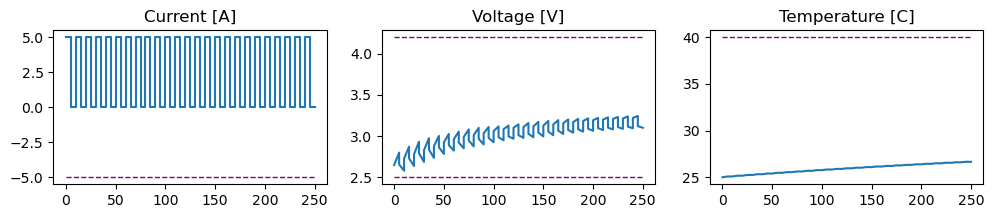

In [38]:
model, protocol = 'spm', 'PC'
start, end = 0, 100
t = globals()[f'sol_{model}_{protocol}']['Time [s]'].entries[start:end]
i = -globals()[f'sol_{model}_{protocol}']['Current [A]'].entries[start:end]
v = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries[start:end]
T = globals()[f'sol_{model}_{protocol}']['Cell temperature [C]'].entries[0][start:end]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
ax1.plot(t, i); ax1.hlines(y=[C], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax1.set_title('Current [A]')
ax2.plot(t, v); ax2.hlines(y=[v_up, v_low], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax2.set_title('Voltage [V]')
ax3.plot(t, T); ax3.hlines(y=[40], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax3.set_title('Temperature [C]')
plt.savefig(f'{model}_{protocol}_{start}_{end}.png', dpi=200)

In [6]:
# 개선된 DFN 모델 설정
dfn = pybamm.lithium_ion.DFN(options={
    'thermal': 'lumped',  # 온도를 간단한 집계 모델로 처리하여 안정성 증가
    "lithium plating": "irreversible",
    "SEI": "constant",  # SEI를 일정한 속도로 성장하도록 설정하여 안정성 확보
})

In [7]:
model, protocol = 'dfn', 'CCCV'
globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'], parameter_values=param, solver=solver)
globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(initial_soc=0)

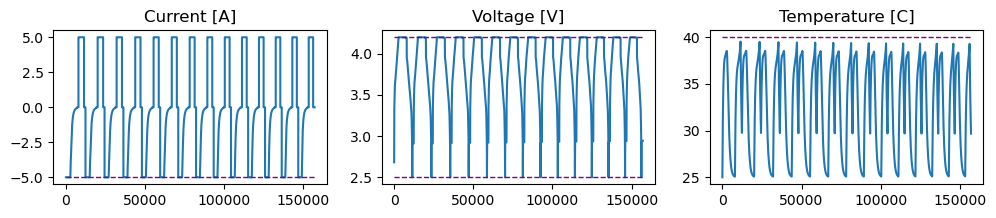

In [8]:
model, protocol = 'dfn', 'CCCV'
t = globals()[f'sol_{model}_{protocol}']['Time [s]'].entries
i = globals()[f'sol_{model}_{protocol}']['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}']['Cell temperature [C]'].entries[0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
ax1.plot(t, i); ax1.hlines(y=[C], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax1.set_title('Current [A]')
ax2.plot(t, v); ax2.hlines(y=[v_up, v_low], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax2.set_title('Voltage [V]')
ax3.plot(t, T); ax3.hlines(y=[40], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax3.set_title('Temperature [C]')
plt.savefig(f'{model}_{protocol}.png', dpi=200)

14
None


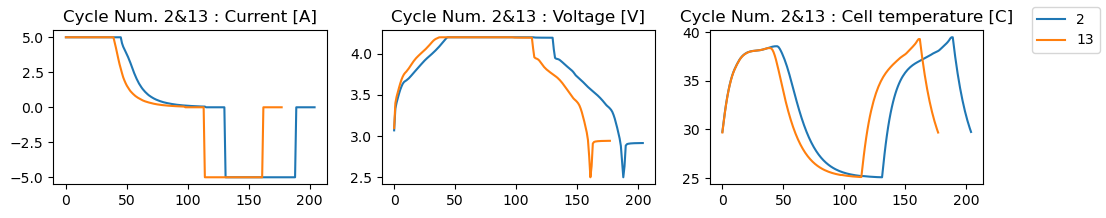

In [40]:
model, protocol = 'dfn', 'CCCV'
print(print(len(globals()[f'sol_{model}_{protocol}'].cycles)))
cycle_num_1, cycle_num_2 = 2, 13

t = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Time [s]'].entries
t = range(len(globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Time [s]'].entries))
i = -globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t, i); ax2.plot(t, v); ax3.plot(t, T)

t = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Time [s]'].entries
t = range(len(globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Time [s]'].entries))
i = -globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
ax1.plot(t, i); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]')
ax2.plot(t, v); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]')
ax3.plot(t, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]')
fig2.legend([f"{cycle_num_1}", f"{cycle_num_2}"], loc="upper right")
plt.savefig(f'{model}_{protocol}_comp.png', dpi=200)

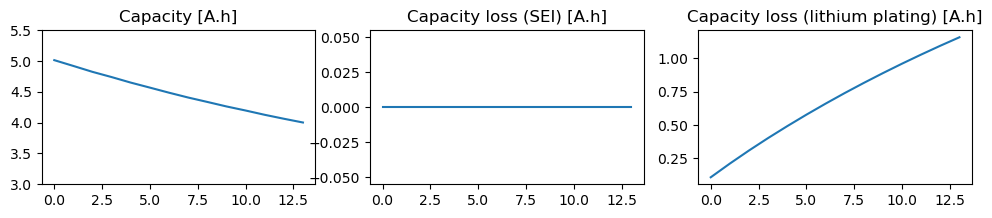

In [12]:
model, protocol = 'dfn', 'CCCV'

t = globals()[f'sol_{model}_{protocol}'].summary_variables['Cycle number']
t = range(len(globals()[f'sol_{model}_{protocol}'].summary_variables['Cycle number']))
c = globals()[f'sol_{model}_{protocol}'].summary_variables['Capacity [A.h]']
dSEI = globals()[f'sol_{model}_{protocol}'].summary_variables['Change in loss of capacity to negative SEI [A.h]']
dli = globals()[f'sol_{model}_{protocol}'].summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
SEI = np.cumsum(dSEI); li = np.cumsum(dli)

fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t, c); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t, SEI); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t, li); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'{model}_{protocol}_summary.png', dpi=200)

In [28]:
model, protocol = 'dfn', 'MCCCV'
globals()[f'sim_{model}_{protocol}'] = pybamm.Simulation(globals()[f'{model}'], experiment=globals()[f'{protocol}'], parameter_values=param, solver=solver)
globals()[f'sol_{model}_{protocol}'] = globals()[f'sim_{model}_{protocol}'].solve(initial_soc=0)

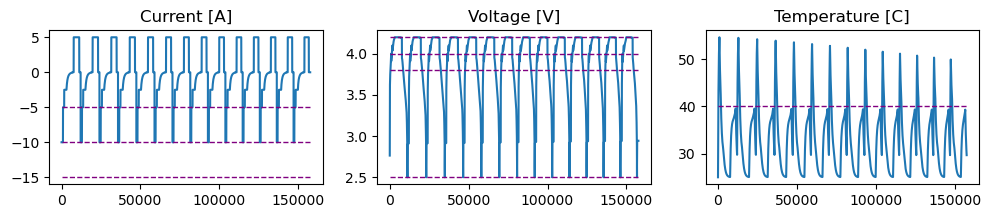

In [29]:
model, protocol = 'dfn', 'MCCCV'
t = globals()[f'sol_{model}_{protocol}']['Time [s]'].entries
i = globals()[f'sol_{model}_{protocol}']['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}']['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}']['Cell temperature [C]'].entries[0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
ax1.plot(t, i); ax1.hlines(y=[3*C, 2*C, C], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax1.set_title('Current [A]')
ax2.plot(t, v); ax2.hlines(y=[v_up-0.4, v_up-0.2, v_up, v_low], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax2.set_title('Voltage [V]')
ax3.plot(t, T); ax3.hlines(y=[40], xmin=t[0], xmax=t[-1], colors='purple', linestyles='--', lw=1); ax3.set_title('Temperature [C]')
plt.savefig(f'{model}_{protocol}.png', dpi=200)

14
None


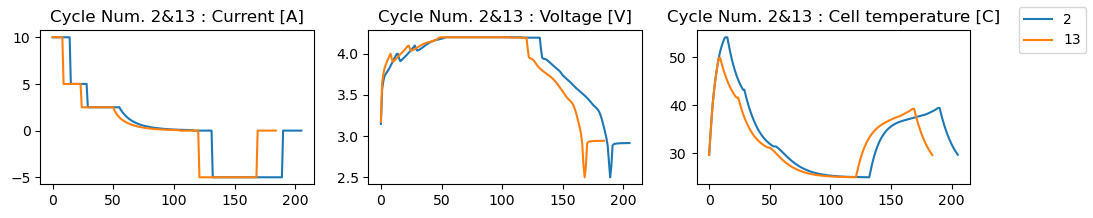

In [39]:
model, protocol = 'dfn', 'MCCCV'
print(print(len(globals()[f'sol_{model}_{protocol}'].cycles)))
cycle_num_1, cycle_num_2 = 2, 13

t = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Time [s]'].entries
t = range(len(globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Time [s]'].entries))
i = -globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_1]['Cell temperature [C]'].entries[0]
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t, i); ax2.plot(t, v); ax3.plot(t, T)

t = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Time [s]'].entries
t = range(len(globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Time [s]'].entries))
i = -globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Current [A]'].entries
v = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Voltage [V]'].entries
T = globals()[f'sol_{model}_{protocol}'].cycles[cycle_num_2]['Cell temperature [C]'].entries[0]
ax1.plot(t, i); ax1.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Current [A]')
ax2.plot(t, v); ax2.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Voltage [V]')
ax3.plot(t, T); ax3.set_title(f'Cycle Num. {cycle_num_1}&{cycle_num_2} : Cell temperature [C]')
fig2.legend([f"{cycle_num_1}", f"{cycle_num_2}"], loc="upper right")
plt.savefig(f'{model}_{protocol}_comp.png', dpi=200)

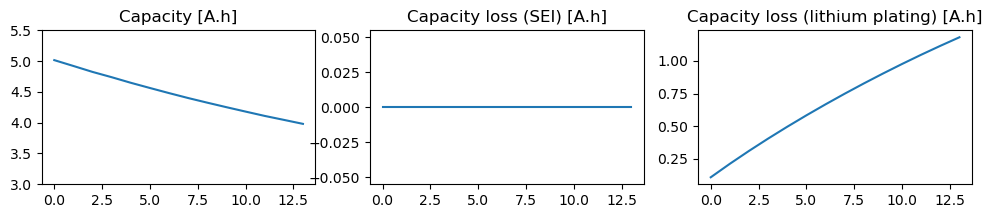

In [35]:
model, protocol = 'dfn', 'MCCCV'

t = globals()[f'sol_{model}_{protocol}'].summary_variables['Cycle number']
t = range(len(globals()[f'sol_{model}_{protocol}'].summary_variables['Cycle number']))
c = globals()[f'sol_{model}_{protocol}'].summary_variables['Capacity [A.h]']
dSEI = globals()[f'sol_{model}_{protocol}'].summary_variables['Change in loss of capacity to negative SEI [A.h]']
dli = globals()[f'sol_{model}_{protocol}'].summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
SEI = np.cumsum(dSEI); li = np.cumsum(dli)

fig3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,2))
ax1.plot(t, c); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
ax2.plot(t, SEI); ax2.set_title(f'Capacity loss (SEI) [A.h]')
ax3.plot(t, li); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
plt.savefig(f'{model}_{protocol}_summary.png', dpi=200)

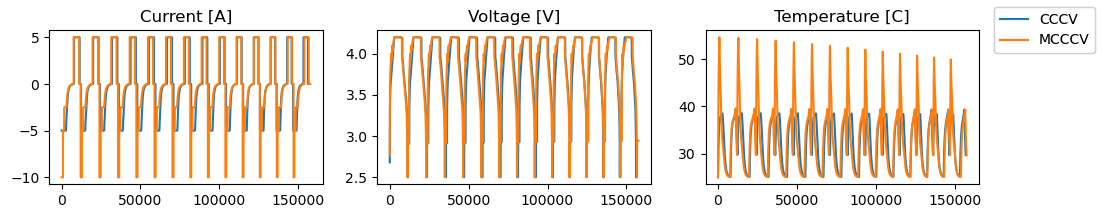

In [36]:
model = "dfn"
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
for prot in ["CCCV", "MCCCV"]:
    t = globals()[f'sol_{model}_{prot}']['Time [s]'].entries
    i = globals()[f'sol_{model}_{prot}']['Current [A]'].entries
    v = globals()[f'sol_{model}_{prot}']['Voltage [V]'].entries
    T = globals()[f'sol_{model}_{prot}']['Cell temperature [C]'].entries[0]
    
    ax1.plot(t, i); ax1.set_title('Current [A]');
    ax2.plot(t, v); ax2.set_title('Voltage [V]');
    ax3.plot(t, T); ax3.set_title('Temperature [C]');
    fig.legend(["CCCV", "MCCCV"], loc="upper right")
plt.savefig(f'{model}_comp_v_t.png', dpi=200)

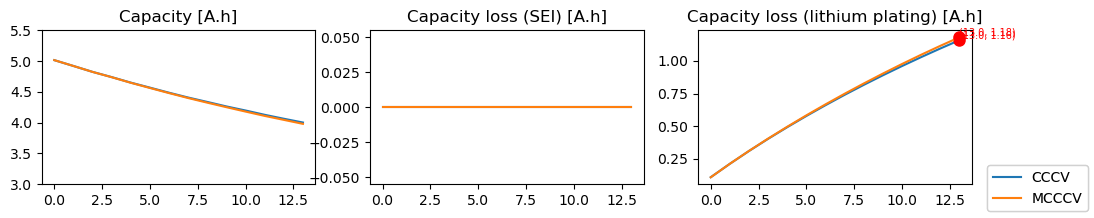

In [41]:
model = "dfn"
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 2))
for prot in ["CCCV", "MCCCV"]:
    t = globals()[f'sol_{model}_{prot}'].summary_variables['Cycle number']
    t = range(len(globals()[f'sol_{model}_{prot}'].summary_variables['Cycle number']))
    c = globals()[f'sol_{model}_{prot}'].summary_variables['Capacity [A.h]']
    dSEI = globals()[f'sol_{model}_{prot}'].summary_variables['Change in loss of capacity to negative SEI [A.h]']
    dli = globals()[f'sol_{model}_{prot}'].summary_variables['Change in loss of capacity to negative lithium plating [A.h]']
    SEI = np.cumsum(dSEI); li = np.cumsum(dli)
    desired_t = t[-1]; SEI_at_desired_t = SEI[-1]; li_at_desired_t = li[-1]
    
    ax1.plot(t, c); ax1.set_ylim([3, 5.5]); ax1.set_title(f'Capacity [A.h]')
    ax2.plot(t, SEI); ax2.set_title(f'Capacity loss (SEI) [A.h]')
    ax3.plot(t, li); ax3.set_title(f'Capacity loss (lithium plating) [A.h]')
    ax3.plot(desired_t, li_at_desired_t, 'ro', markersize=8)
    ax3.text(desired_t, li_at_desired_t, f"({desired_t:.1f}, {li_at_desired_t:.2f})", color='red', fontsize=7, verticalalignment='bottom')
    fig.legend(["CCCV", "MCCCV"], loc="lower right")
plt.savefig(f'{model}_comp_summary.png', dpi=200)